# Cybersecurity Network Flow Analysis

This notebook analyzes network flow data from a cybersecurity dataset.  
The goal is to understand traffic behaviors, detect potential attack patterns, and identify features that distinguish normal from malicious activity.
Apply a Machine Learning model — Random Forest Classifier — to automatically classify and predict cyberattacks based on network traffic characteristics.

The Random Forest model was chosen for its robustness, ability to handle large feature sets, and strong performance in distinguishing between normal and attack traffic.
It learns from multiple decision trees to make accurate predictions, providing insights into feature importance and enabling effective intrusion detection.

### Objectives:
- Explore network traffic distribution and statistics.
- Identify the most common attack categories.
- Analyze key features such as protocol, service, and data rates.
- Prepare the dataset for potential intrusion detection modeling.

Let's dive into the analysis.

The following are the major libraries that am going to use for this task.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn as sk

##  Load and Inspect Data
We begin by loading the dataset and reviewing its structure to understand the available features.


In [5]:
data  = pd.read_csv('/var/www/html/projects/data analytics/UNSW_NB15_training-set.csv')

In [ ]:
## the following is the code to check your data
print("Dataset shape:", data.shape)
data.head()

##  Data Cleaning and Feature Selection
The dataset contains 45 columns describing network connections.  
We’ll remove non-informative or highly technical fields to simplify analysis and keep the most relevant features.


In [8]:
# Drop non-informative column
data.drop(columns=['id'], inplace=True, errors='ignore')

# Drop very specific TCP-level features (optional)
low_level_cols = ['stcpb', 'dtcpb', 'swin', 'dwin', 'tcprtt', 'synack', 'ackdat']
data.drop(columns=low_level_cols, inplace=True, errors='ignore')

# Confirm remaining columns
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dur                82332 non-null  float64
 1   proto              82332 non-null  object 
 2   service            82332 non-null  object 
 3   state              82332 non-null  object 
 4   spkts              82332 non-null  int64  
 5   dpkts              82332 non-null  int64  
 6   sbytes             82332 non-null  int64  
 7   dbytes             82332 non-null  int64  
 8   rate               82332 non-null  float64
 9   sttl               82332 non-null  int64  
 10  dttl               82332 non-null  int64  
 11  sload              82332 non-null  float64
 12  dload              82332 non-null  float64
 13  sloss              82332 non-null  int64  
 14  dloss              82332 non-null  int64  
 15  sinpkt             82332 non-null  float64
 16  dinpkt             823

##  Data Overview
Let's explore key features such as protocols, services, and attack categories.


In [9]:
# Summary statistics
data.describe(include='all').T.head(10)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
dur,82332.0,NaN,NaN,NaN,1.006756,4.710444,0.0,0.000008,0.014138,0.71936,59.999989
proto,82332,131,tcp,43095,NaN,NaN,NaN,NaN,NaN,NaN,NaN
service,82332,13,-,47153,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,82332,7,FIN,39339,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spkts,82332.0,NaN,NaN,NaN,18.666472,133.916353,1.0,2.0,6.0,12.0,10646.0
dpkts,82332.0,NaN,NaN,NaN,17.545936,115.574086,0.0,0.0,2.0,10.0,11018.0
sbytes,82332.0,NaN,NaN,NaN,7993.908165,171642.26188,24.0,114.0,534.0,1280.0,14355774.0
dbytes,82332.0,NaN,NaN,NaN,13233.785563,151471.456091,0.0,0.0,178.0,956.0,14657531.0
rate,82332.0,NaN,NaN,NaN,82410.886739,148620.367041,0.0,28.606114,2650.176667,111111.1072,1000000.003
sttl,82332.0,NaN,NaN,NaN,180.967667,101.513358,0.0,62.0,254.0,254.0,255.0


In [10]:
# Unique attack categories
print("Attack Categories:", data['attack_cat'].unique())
print("\nLabel counts:\n", data['label'].value_counts())


Attack Categories: ['Normal' 'Reconnaissance' 'Backdoor' 'DoS' 'Exploits' 'Analysis'
 'Fuzzers' 'Worms' 'Shellcode' 'Generic']

Label counts:
 label
1    45332
0    37000
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

We visualize traffic and attack patterns to uncover trends and anomalies.


/tmp/ipykernel_3331/3550049548.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='coolwarm')


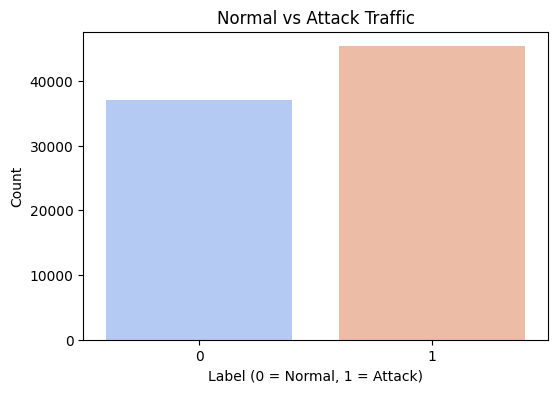

In [11]:
# Distribution of normal vs attack
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data, palette='coolwarm')
plt.title("Normal vs Attack Traffic")
plt.xlabel("Label (0 = Normal, 1 = Attack)")
plt.ylabel("Count")
plt.show()


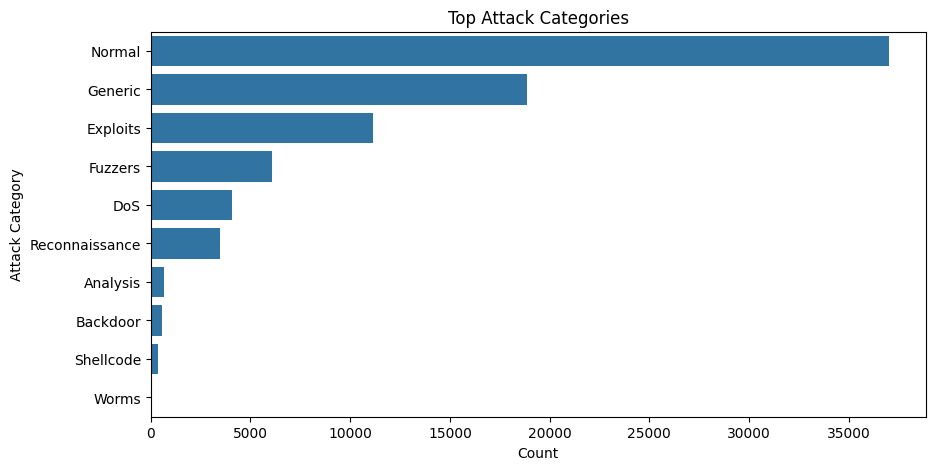

In [12]:
# Top attack categories
plt.figure(figsize=(10,5))
sns.countplot(y='attack_cat', data=data, order=data['attack_cat'].value_counts().index)
plt.title("Top Attack Categories")
plt.xlabel("Count")
plt.ylabel("Attack Category")
plt.show()


### Protocol Distribution
The dataset includes multiple network protocols.  
To improve visibility, the chart below displays the most frequently used ones in descending order.


/tmp/ipykernel_3331/3237191864.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


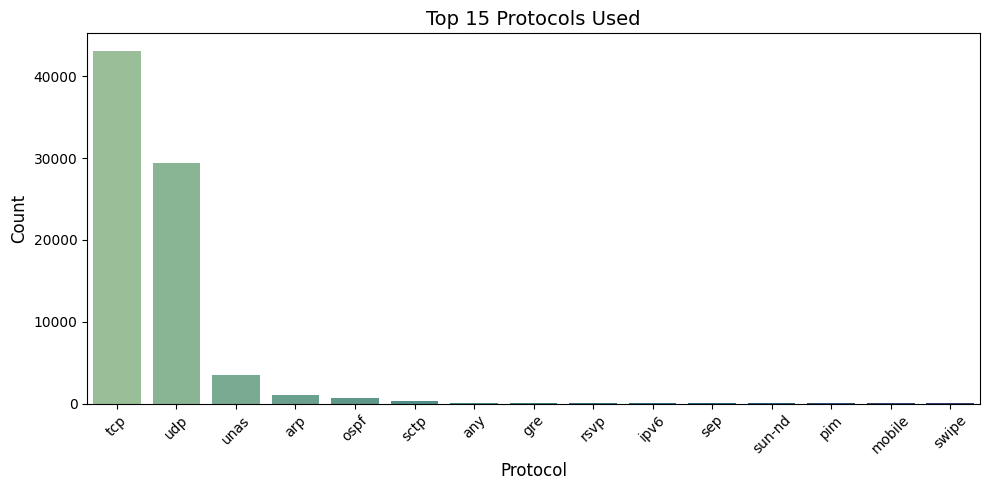

In [22]:
top_protocols = data['proto'].value_counts().nlargest(15).index

plt.figure(figsize=(10,5))
sns.countplot(
    x='proto',
    data=data[data['proto'].isin(top_protocols)],
    order=top_protocols,
    palette='crest'
)
plt.title("Top 15 Protocols Used", fontsize=14)
plt.xlabel("Protocol", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


##  Insights.

From the exploratory analysis:
- The dataset contains both **normal** and **attack** traffic, with clear labeling.
- The **UDP** and **TCP** protocols dominate network communication.
- A few attack categories (e.g., *DoS*, *Fuzzers*, *Reconnaissance*) appear more frequently.
- High `rate` and `sbytes/dbytes` values may indicate abnormal connections.



## Correlation and Feature Importance

In this section, we explore how numerical features relate to one another and to the target labels.  
Correlation analysis helps identify which variables are most relevant for detecting attacks.  
High correlation between features may indicate redundancy, while strong correlation with the target may reveal predictive power.


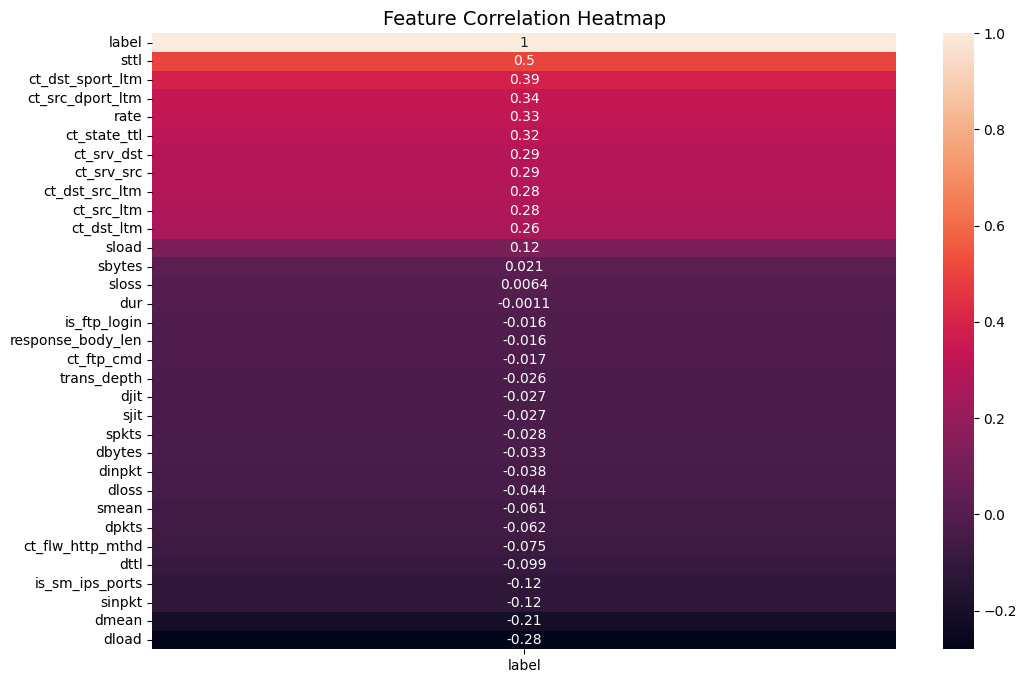

In [24]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Compute correlation matrix
corr = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr[['label']].sort_values(by='label', ascending=False), annot=True)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()


### Correlation Insights
- Some features (like `sbytes`, `rate`, and `ct_state_ttl`) show stronger correlation with the attack label.
- Features with very high inter-correlation can be candidates for dimensionality reduction. This means that If two or more features are too similar (they give almost the same information), then we don’t need to keep all of them — we can remove or combine some to make the data smaller and cleaner.
Example:

Imagine your dataset has these features:

sbytes (source bytes sent)

dbytes (destination bytes received)

total_bytes (sum of both)

Here, total_bytes is highly correlated with sbytes and dbytes — they all describe the same thing (amount of data).
Keeping all three doesn’t add new information — it can confuse the model or slow it down.
- Understanding these relationships is useful before applying machine learning models.


## Machine Learning for Intrusion Detection

We now train a simple machine learning model to automatically classify network flows as *Normal* or *Attack*.  
We’ll use a **Random Forest Classifier**, known for its robustness and feature importance interpretability.


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Encode categorical variables
data_encoded = pd.get_dummies(data.drop(columns=['attack_cat']), drop_first=True)

# Split into features (X) and target (y)
X = data_encoded.drop(columns=['label'])
y = data_encoded['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Training set:", X_train.shape)
print("Test set:", X_test.shape)


Training set: (57632, 180)
Test set: (24700, 180)


In [29]:
# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97     11100
           1       0.98      0.97      0.98     13600

    accuracy                           0.98     24700
   macro avg       0.98      0.98      0.98     24700
weighted avg       0.98      0.98      0.98     24700



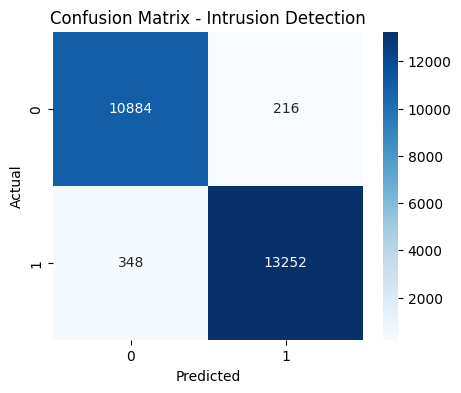

In [30]:
# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Intrusion Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### Model Insights
- **Precision** measures how many predicted attacks were actual attacks. in simple terms, Out of all the traffic the model said was an attack, how many really were attacks? example, there were over 100 attacks but the actual attacks were 97, so precision will be 97/100 = 0.97.   
- **Recall** measures how many real attacks the model correctly detected. Simply, Out of all the real attacks, how many did the model actually catch?
- **F1-score** provides a balance between both metrics.  This combines Precision and Recall into one score.
It’s a balance between catching most attacks (recall) and not crying wolf too often (precision).

If the model:

Has high recall but low precision → it finds most attacks but gives many false alarms.

Has high precision but low recall → it rarely gives false alarms, but misses some attacks.

The F1-score gives you a single number that balances both.

A high recall but moderate precision suggests the model detects most attacks but might misclassify some normal flows.  
This trade-off can be tuned with threshold adjustments or feature selection.


/tmp/ipykernel_3331/3983148956.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='crest')


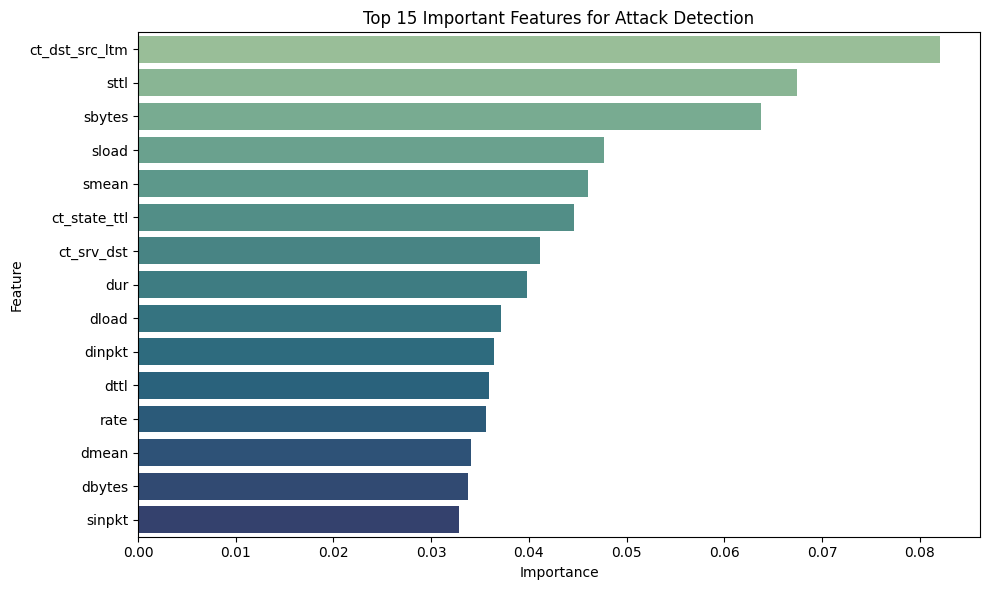

In [32]:
# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.nlargest(15)

plt.figure(figsize=(10,6))
sns.barplot(x=top_features.values, y=top_features.index, palette='crest')
plt.title("Top 15 Important Features for Attack Detection")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Conclusion

This notebook demonstrated how to:
- Clean and explore a cybersecurity dataset.
- Visualize traffic and attack patterns.
- Analyze correlations between features.
- Build a baseline **Random Forest model** for intrusion detection.


